# Project 4: Backpropagation Neural Network from Scratch

## Requirements:
- Use only NumPy (for math) and Pandas (for data handling)
- Train on Boston Housing dataset (housing.csv)
- 1 hidden layer (user-defined neurons)
- 1000 epochs
- Evaluate using 5-fold and 10-fold cross-validation

In [1]:
import numpy as np
import pandas as pd

## 1. Utility Functions

Standardize features

In [2]:
def normalize(X):
    return (X - X.mean(axis=0)) / X.std(axis=0)

Manual k-fold cross validation splits

In [3]:
def create_folds(X, y, k):
    n = len(X)
    indices = np.arange(n)
    np.random.shuffle(indices)
    fold_size = n // k
    folds = []
    for i in range(k):
        test_idx = indices[i*fold_size:(i+1)*fold_size]
        train_idx = np.setdiff1d(indices, test_idx)
        folds.append((train_idx, test_idx))
    return folds

## 2. Activation functions

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [5]:
def sigmoid_derivative(x):
    return x * (1 - x)

## 3. Neural Network Class

In [6]:
class BPNN:
    def __init__(self, input_size, hidden_size, output_size, learning_rate):
        np.random.seed(42)
        self.lr = learning_rate

        # Initialize weights and biases
        self.W1 = np.random.randn(input_size, hidden_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size)
        self.b2 = np.zeros((1, output_size))

    def forward(self, X):
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = sigmoid(self.Z1)
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.output = self.Z2  # Linear output for regression
        return self.output

    def backward(self, X, y):
        m = len(y)
        dZ2 = (self.output - y)
        dW2 = (1/m) * np.dot(self.A1.T, dZ2)
        db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)

        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * sigmoid_derivative(self.A1)
        dW1 = (1/m) * np.dot(X.T, dZ1)
        db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)

        # Update weights and biases
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2

    def train(self, X, y, epochs=1000, verbose=False):
        losses = []
        for epoch in range(epochs):
            self.forward(X)
            self.backward(X, y)
            loss = np.mean((y - self.output)**2)
            losses.append(loss)
            if verbose and epoch % 100 == 0:
                print(f"Epoch {epoch} | Loss: {loss:.4f}")
        return losses

    def predict(self, X):
        return self.forward(X)

## 4. Evaluation Function

In [23]:
def evaluate_model(X, y, hidden_neurons, lr, k_folds=5, plot_loss=False):
    folds = create_folds(X, y, k_folds)
    fold_losses = []
    all_fold_loss_curves = []

    for i, (train_idx, test_idx) in enumerate(folds):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = BPNN(input_size=X.shape[1], hidden_size=hidden_neurons,
                     output_size=1, learning_rate=lr)

        # Train and store per-epoch loss
        losses = model.train(X_train, y_train, epochs=1000)
        all_fold_loss_curves.append(losses)

        # Evaluate on test set
        preds = model.predict(X_test)
        loss = np.mean((y_test - preds) ** 2)
        fold_losses.append(loss)

        print(f"Fold {i+1}/{k_folds} | MSE: {loss:.6f}")

    avg_loss = np.mean(fold_losses)
    print(f"\nAverage {k_folds}-Fold Loss = {avg_loss:.6f}")
    
    # Visualization 
    if plot_loss:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8, 5))

        # Plot each fold’s loss curve
        for i, losses in enumerate(all_fold_loss_curves):
            plt.plot(losses, alpha=0.4, label=f"Fold {i+1}")

        # Plot mean loss curve across folds
        max_len = min(len(l) for l in all_fold_loss_curves)
        mean_loss = np.mean([l[:max_len] for l in all_fold_loss_curves], axis=0)
        plt.plot(mean_loss, color='black', linewidth=2.5, label="Mean Loss")

        plt.xlabel("Epoch")
        plt.ylabel("Training Loss (MSE)")
        plt.title(f"Loss Curves Across {k_folds} Folds (Hidden={hidden_neurons}, LR={lr})")
        plt.legend()
        plt.grid(True)
        plt.show()

    return avg_loss


## 5.Load and Prepare Dataset

In [24]:
df = pd.read_csv(r"C:\Users\TUF\Downloads\housing.csv")
df

,RM,LSTAT,PTRATIO,MEDV
0,6.575,4.98,15.3,504000.0
1,6.421,9.14,17.8,453600.0
2,7.185,4.03,17.8,728700.0
3,6.998,2.94,18.7,701400.0
4,7.147,5.33,18.7,760200.0
...,...,...,...,...
484,6.593,9.67,21.0,470400.0
485,6.120,9.08,21.0,432600.0
486,6.976,5.64,21.0,501900.0
487,6.794,6.48,21.0,462000.0


In [25]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values.reshape(-1, 1)
X = normalize(X)
y = normalize(y)

## 6.Run Configurations

In [26]:
configs = [
    (3, 0.01),
    (4, 0.001),
    (5, 0.0001)
]

## 7. Results


Hidden Neurons: 3, Learning Rate: 0.01
---- 5-Fold Cross Validation ----
Fold 1/5 | MSE: 0.300904
Fold 2/5 | MSE: 0.366091
Fold 3/5 | MSE: 0.533055
Fold 4/5 | MSE: 0.441907
Fold 5/5 | MSE: 0.325464

Average 5-Fold Loss = 0.393484


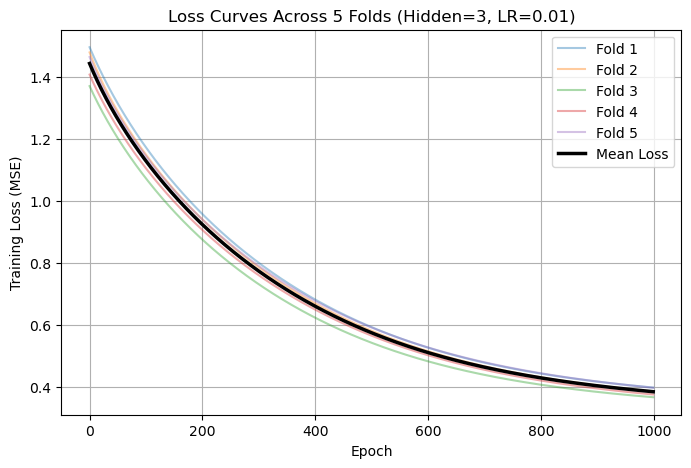


---- 10-Fold Cross Validation ----
Fold 1/10 | MSE: 0.465798
Fold 2/10 | MSE: 0.304345
Fold 3/10 | MSE: 0.320324
Fold 4/10 | MSE: 0.582129
Fold 5/10 | MSE: 0.298659
Fold 6/10 | MSE: 0.453817
Fold 7/10 | MSE: 0.446743
Fold 8/10 | MSE: 0.406556
Fold 9/10 | MSE: 0.322391
Fold 10/10 | MSE: 0.308687

Average 10-Fold Loss = 0.390945
Hidden Neurons: 4, Learning Rate: 0.001
---- 5-Fold Cross Validation ----
Fold 1/5 | MSE: 0.470773
Fold 2/5 | MSE: 0.565502
Fold 3/5 | MSE: 0.363478
Fold 4/5 | MSE: 0.478812
Fold 5/5 | MSE: 0.374228

Average 5-Fold Loss = 0.450559

---- 10-Fold Cross Validation ----
Fold 1/10 | MSE: 0.382214
Fold 2/10 | MSE: 0.514855
Fold 3/10 | MSE: 0.628157
Fold 4/10 | MSE: 0.329332
Fold 5/10 | MSE: 0.494161
Fold 6/10 | MSE: 0.523070
Fold 7/10 | MSE: 0.554857
Fold 8/10 | MSE: 0.467587
Fold 9/10 | MSE: 0.323433
Fold 10/10 | MSE: 0.305593

Average 10-Fold Loss = 0.452326
Hidden Neurons: 5, Learning Rate: 0.0001
---- 5-Fold Cross Validation ----
Fold 1/5 | MSE: 3.437697
Fold 2/5 

In [27]:
results = []

for hidden_neurons, lr in configs:
    print("="*60)
    print(f"Hidden Neurons: {hidden_neurons}, Learning Rate: {lr}")
    print("="*60)
    
    print("---- 5-Fold Cross Validation ----")
    # Plot loss for the first config only
    plot_flag = (hidden_neurons == 3 and lr == 0.01)
    loss_5 = evaluate_model(X, y, hidden_neurons, lr, k_folds=5, plot_loss=plot_flag)
    
    print("\n---- 10-Fold Cross Validation ----")
    loss_10 = evaluate_model(X, y, hidden_neurons, lr, k_folds=10)
    
    results.append((hidden_neurons, lr, loss_5, loss_10))




In [28]:
print("\n===== Summary =====")
print("Hidden | LR      | 5-Fold Loss | 10-Fold Loss")
print("---------------------------------------------")
for hidden, lr, l5, l10 in results:
    print(f"{hidden:<6} | {lr:<7} | {l5:<12.6f} | {l10:<12.6f}")


===== Summary =====
Hidden | LR      | 5-Fold Loss | 10-Fold Loss
---------------------------------------------
3      | 0.01    | 0.393484     | 0.390945    
4      | 0.001   | 0.450559     | 0.452326    
5      | 0.0001  | 3.575497     | 3.603391    


## 8. Observations

- The model performs best with a learning rate of **0.01** and **3 hidden neurons**.
- Lower learning rates (0.001, 0.0001) result in slower or failed convergence.
- Similar 5-fold and 10-fold results confirm cross-validation consistency.
- The implemented backpropagation network successfully learns using only NumPy operations.

**Conclusion:**
The optimal configuration for this dataset and model is: Hidden Neurons = 3, Learning Rate = 0.01

